시공간 정보로부터 사고위험도(ECLO)를 예측하는 AI 알고리즘

In [75]:
!pip install optuna
import optuna
import xgboost as xgb
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

child_df = pd.read_csv('/content/drive/MyDrive/colab/daegu_traffic/external_open/대구_어린이_보호_구역_정보.csv', encoding='cp949')
cctv_df = pd.read_csv('/content/drive/MyDrive/colab/daegu_traffic/external_open/대구_CCTV_정보.csv', encoding='cp949')

train_org = pd.read_csv('/content/drive/MyDrive/colab/daegu_traffic/train.csv')
train_org = train_org.drop(columns=train_org.iloc[:,8:22])
test_org = pd.read_csv('/content/drive/MyDrive/colab/daegu_traffic/test.csv')
train_org.info()
test_org.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39609 entries, 0 to 39608
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      39609 non-null  object
 1   사고일시    39609 non-null  object
 2   요일      39609 non-null  object
 3   기상상태    39609 non-null  object
 4   시군구     39609 non-null  object
 5   도로형태    39609 non-null  object
 6   노면상태    39609 non-null  object
 7   사고유형    39609 non-null  object
 8   ECLO    39609 non-null  int64 
dtypes: int64(1), object(8)
memory usage: 2.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10963 entries, 0 to 10962
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      10963 non-null  object
 1   사고일시    10963 non-null  object
 2   요일      10963 non-null  object
 3   기상상태    10963 non-null  object
 4   시군구     10963 non-null  object
 5   도로형태    10963 non-null  object
 6   노면상태    10963 non-null  object
 7   사고유형    1

In [76]:
#텍스트 나누기

train_df = train_org.copy()
test_df = test_org.copy()

time_pattern = r'(\d{4})-(\d{1,2})-(\d{1,2}) (\d{1,2})'

train_df[['연', '월', '일', '시간']] = train_org['사고일시'].str.extract(time_pattern)
train_df[['연', '월', '일', '시간']] = train_df[['연', '월', '일', '시간']].apply(pd.to_numeric) # 추출된 문자열을 수치화해줍니다
train_df = train_df.drop(columns=['사고일시']) # 정보 추출이 완료된 '사고일시' 컬럼은 제거합니다

# 해당 과정을 test_x에 대해서도 반복해줍니다
test_df[['연', '월', '일', '시간']] = test_org['사고일시'].str.extract(time_pattern)
test_df[['연', '월', '일', '시간']] = test_df[['연', '월', '일', '시간']].apply(pd.to_numeric)
test_df = test_df.drop(columns=['사고일시'])

display(f"columns of train_df : {train_df.columns}")
display(f"columns of test_df : {test_df.columns}")

location_pattern = r'(\S+) (\S+) (\S+)'

train_df[['도시', '구', '동']] = train_org['시군구'].str.extract(location_pattern)
train_df = train_df.drop(columns=['시군구'])

test_df[['도시', '구', '동']] = test_org['시군구'].str.extract(location_pattern)
test_df = test_df.drop(columns=['시군구'])

display(f"columns of train_df : {train_df.columns}")
display(f"columns of test_df : {test_df.columns}")

road_pattern = r'(.+) - (.+)'

train_df[['도로형태1', '도로형태2']] = train_org['도로형태'].str.extract(road_pattern)
train_df = train_df.drop(columns=['도로형태'])

test_df[['도로형태1', '도로형태2']] = test_org['도로형태'].str.extract(road_pattern)
test_df = test_df.drop(columns=['도로형태'])

display(f"columns of train_df : {train_df.columns}")
display(f"columns of test_df : {test_df.columns}")

"columns of train_df : Index(['ID', '요일', '기상상태', '시군구', '도로형태', '노면상태', '사고유형', 'ECLO', '연', '월',\n       '일', '시간'],\n      dtype='object')"

"columns of test_df : Index(['ID', '요일', '기상상태', '시군구', '도로형태', '노면상태', '사고유형', '연', '월', '일', '시간'], dtype='object')"

"columns of train_df : Index(['ID', '요일', '기상상태', '도로형태', '노면상태', '사고유형', 'ECLO', '연', '월', '일', '시간',\n       '도시', '구', '동'],\n      dtype='object')"

"columns of test_df : Index(['ID', '요일', '기상상태', '도로형태', '노면상태', '사고유형', '연', '월', '일', '시간', '도시',\n       '구', '동'],\n      dtype='object')"

"columns of train_df : Index(['ID', '요일', '기상상태', '노면상태', '사고유형', 'ECLO', '연', '월', '일', '시간', '도시',\n       '구', '동', '도로형태1', '도로형태2'],\n      dtype='object')"

"columns of test_df : Index(['ID', '요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '도시', '구', '동',\n       '도로형태1', '도로형태2'],\n      dtype='object')"

In [77]:
#직선, 혼잡, 골목, 시골 주관적 분리
road_feature_df = pd.read_csv('/content/drive/MyDrive/colab/daegu_traffic/도로형태3.csv')
train_df = pd.merge(train_df, road_feature_df, on='동', how='inner')
train_df.shape

test_df = pd.merge(test_df, road_feature_df, on='동', how='inner')
test_df.shape

ID       0
요일       0
기상상태     0
노면상태     0
사고유형     0
ECLO     0
연        0
월        0
일        0
시간       0
도시       0
구        0
동        0
도로형태1    0
도로형태2    0
도로형태3    0
dtype: int64
ID       0
요일       0
기상상태     0
노면상태     0
사고유형     0
연        0
월        0
일        0
시간       0
도시       0
구        0
동        0
도로형태1    0
도로형태2    0
도로형태3    0
dtype: int64


트레인 테스트에 cctv정보추가

In [78]:
location_pattern = r'(\S+) (\S+) (\S+) (\S+)'

child_df[['도시', '구', '동','번지']] = child_df['소재지지번주소'].str.extract(location_pattern)
child_df = child_df.drop(columns=['소재지지번주소'])
child_df

,시설종류,대상시설명,소재지도로명주소,위도,경도,관리기관명,관할경찰서명,CCTV설치여부,CCTV설치대수,보호구역도로폭,데이터기준일자,도시,구,동,번지
0,초등학교,남도초등학교,대구광역시 남구 현충동길 74(대명동),35.845027,128.581402,대구광역시,남부경찰서,Y,7.0,6~8,2020-03-23,대구광역시,남구,대명동,1709
1,초등학교,영선초등학교,대구광역시 남구 영선길96(이천동),35.852901,128.596014,대구광역시,남부경찰서,Y,8.0,6~10,2020-03-23,대구광역시,남구,이천동,477
2,초등학교,성명초등학교,대구광역시 남구 성당로 30길 55(대명동),35.845152,128.570825,대구광역시,남부경찰서,Y,14.0,8~12,2020-03-23,대구광역시,남구,대명동,3050
3,초등학교,남덕초등학교,대구광역시 남구 앞산순환로 93길 33,35.833042,128.573949,대구광역시,남부경찰서,Y,6.0,6~8,2020-03-23,대구광역시,남구,대명동,531-1
4,초등학교,대명초등학교,대구광역시 남구 대명로 110,35.838869,128.568889,대구광역시,남부경찰서,Y,5.0,6~10,2020-03-23,대구광역시,남구,대명동,960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,어린이집,남산교회어린이집,대구광역시 중구 관덕정길 16,35.865040,128.590565,대구광역시 중구청,대구광역시 중부경찰서,Y,5.0,6~10,2019-06-01,대구광역시,중구,남산동,941-1
636,초등학교,대구초등학교,대구광역시 중구 명륜로23길 80,35.864037,128.595370,대구광역시 중구청,대구광역시 중부경찰서,Y,12.0,3~12,2019-06-01,대구광역시,중구,봉산동,57
637,어린이집,대구삼성어린이집,대구광역시 중구 달구벌대로 2016-40,35.864469,128.584301,대구광역시 중구청,대구광역시 중부경찰서,Y,2.0,7~8,2019-06-01,대구광역시,중구,남산동,153-2
638,어린이집,동화나라어린이집,대구광역시 중구 남산로3안길 20,35.860371,128.577492,대구광역시 중구청,대구광역시 중부경찰서,Y,5.0,6~8,2019-06-01,대구광역시,중구,남산동,2623-6


In [79]:
print(child_df['CCTV설치대수'].unique()) #4는 주차카메라
print(child_df['동'].unique())
print(train_df['동'].unique())

[ 7.  8. 14.  6.  5.  9. 10.  4.  2.  3.  1.  0. 11. nan 12.]
['대명동' '이천동' '봉덕동' '가창면' '구지면' '옥포면' '논공읍' '화원읍' '다사읍' '하빈면' '유가읍' '현풍면'
 nan '태전동' '구암동' '복현동' '관음동' '읍내동' '산격동' '국우동' '침산동' '매천동' '동천동' '사수동'
 '동변동' '서변동' '학정동' '대현동' '검단동' '노원동1가' '도남동' '고성동2가' '칠성동2가' '조야동' '팔달동'
 '고성동1가' '내당동' '중리동' '원대동1가' '비산동' '평리동' '이현동' '수성동4가' '노변동' '황금동' '만촌동'
 '범어동' '수성동1가' '두산동' '신매동' '파동' '상동' '매호동' '욱수동' '지산동' '중동' '시지동' '범물동'
 '수성동3가' '사월동' '수성동2가' '수창동' '남산동' '서문로1가' '삼덕동3가' '동인동4가' '봉산동' '대신동'
 '삼덕동2가' '남일동' '덕산동' '동산동']
['대신동' '감삼동' '두산동' '복현동' '신암동' '지산동' '상인동' '태전동' '지묘동' '평리동' '신기동' '상리동'
 '월성동' '황금동' '구암동' '신천동' '만촌동' '남산동' '비산동' '침산동' '두류동' '신매동' '대곡동' '유가읍'
 '논공읍' '율하동' '시지동' '봉무동' '다사읍' '동산동' '이현동' '이천동' '수성동4가' '노원동3가' '서변동'
 '관음동' '학정동' '파동' '상동' '이곡동' '효목동' '읍내동' '남성로' '죽전동' '대명동' '동천동' '지저동'
 '사수동' '덕산동' '본리동' '용계동' '범어동' '신당동' '성당동' '용산동' '태평로3가' '도학동' '욱수동' '불로동'
 '칠성동1가' '장기동' '매호동' '대천동' '삼덕동1가' '수성동2가' '팔달동' '삼덕동' '진천동' '수성동3가' '가창면'
 '방촌동' '산격동' '월암동' '현풍읍' '구지면' '매천동' '송

In [80]:
child_cctv_df = {'동':[],
                 '어린이CCTV설치대수':[]}
child_cctv_df = pd.DataFrame(child_cctv_df)

#동마다 CCTV 갯수 넣을꺼
temp_list = []
for i in child_df['동'].unique() :
  temp_list.append(len(child_df[child_df['동']==i].loc[:,'CCTV설치대수']))

child_cctv_df['동'] = child_df['동'].unique()
child_cctv_df['어린이CCTV설치대수'] = temp_list
child_cctv_df = child_cctv_df.dropna(axis=0) #nan값이 하나 있어서

#train, test 어린이cctv여부 추가

train_df = pd.merge(train_df, child_cctv_df, on='동', how='left')
print(train_df.shape)
train_df = train_df.fillna(0)

test_df = pd.merge(test_df, child_cctv_df, on='동', how='left')
print(test_df.shape)
test_df = test_df.fillna(0)

(39609, 17)
ID             0
요일             0
기상상태           0
노면상태           0
사고유형           0
ECLO           0
연              0
월              0
일              0
시간             0
도시             0
구              0
동              0
도로형태1          0
도로형태2          0
도로형태3          0
어린이CCTV설치대수    0
dtype: int64
(10963, 16)
ID             0
요일             0
기상상태           0
노면상태           0
사고유형           0
연              0
월              0
일              0
시간             0
도시             0
구              0
동              0
도로형태1          0
도로형태2          0
도로형태3          0
어린이CCTV설치대수    0
dtype: int64


In [81]:
location_pattern = r'(\S+) (\S+) (\S+) (\S+)'

cctv_df[['도시', '구', '동','번지']] = cctv_df['소재지지번주소'].str.extract(location_pattern)
cctv_df = cctv_df.drop(columns=['소재지지번주소'])
cctv_df

,무인교통단속카메라관리번호,시도명,시군구명,도로종류,도로노선번호,도로노선명,도로노선방향,소재지도로명주소,위도,경도,...,단속구분,제한속도,단속구간위치구분,과속단속구간길이,보호구역구분,설치연도,도시,구,동,번지
0,주차12,대구광역시,남구,시도,NaN,대명로,3,대구광역시 남구 대명로 162,35.838857,128.575418,...,4,0,NaN,NaN,99.0,2010.0,대구광역시,남구,대명동,903-13
1,주차13,대구광역시,남구,시도,NaN,봉덕로,3,대구광역시 남구 봉덕로 135,35.844653,128.604619,...,4,0,NaN,NaN,99.0,2013.0,대구광역시,남구,봉덕동,853-8
2,주차14,대구광역시,남구,시도,NaN,대봉로,3,대구광역시 남구 봉덕로 134,35.844183,128.604815,...,4,0,NaN,NaN,99.0,2013.0,대구광역시,남구,봉덕동,866-46
3,주차15,대구광역시,남구,시도,NaN,큰골길,3,대구광역시 남구 큰골길 200,35.834798,128.585284,...,4,0,NaN,NaN,99.0,2014.0,대구광역시,남구,대명동,2680-17
4,주차16,대구광역시,남구,시도,NaN,큰골길,3,대구광역시 남구 큰골길 243,35.832728,128.588324,...,4,0,NaN,NaN,99.0,2014.0,대구광역시,남구,봉덕동,1616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1060,H2418,대구광역시,북구,특별시도,NaN,태암남로,1,대구광역시 북구 태암남로 41,35.925294,128.552023,...,2,40,NaN,NaN,99.0,2021.0,대구광역시,북구,구암동,671-8
1061,H2419,대구광역시,북구,특별시도,NaN,내곡로,1,대구광역시 북구 내곡로 90,35.900977,128.513825,...,2,30,NaN,NaN,2.0,2021.0,대구광역시,북구,사수동,812
1062,H4145,대구광역시,북구,특별시도,NaN,대현로,2,대구광역시 북구 대현로 100,35.882191,128.609791,...,2,30,NaN,NaN,2.0,2021.0,대구광역시,북구,대현동,270-8
1063,H4146,대구광역시,북구,특별시도,NaN,대현로,1,대구광역시 북구 대현로 118,35.881737,128.611651,...,2,30,NaN,NaN,2.0,2021.0,대구광역시,북구,대현동,270-3


In [ ]:
print(cctv_df['단속구분'].unique()) #4는 주차카메라

In [83]:
cctv_list = {'동':[],
             'CCTV개수':[]}
cctv_list = pd.DataFrame(cctv_list)
#동마다 CCTV 갯수 넣을꺼
temp_list = []
for i in cctv_df['동'].unique() :
  temp_list.append(len(cctv_df[(cctv_df['동']==i)&((cctv_df['단속구분']==2)|(cctv_df['단속구분']==1)|(cctv_df['단속구분']==99))]))

cctv_list['동'] = cctv_df['동'].unique()
cctv_list['CCTV개수'] = temp_list
cctv_list = cctv_list.dropna(axis=0) #nan값이 하나 있어서

#train, test cctv_list 추가

train_df = pd.merge(train_df, cctv_list, on='동', how='left')
print(train_df.shape)
train_df = train_df.fillna(0)

test_df = pd.merge(test_df, cctv_list, on='동', how='left')
print(test_df.shape)
test_df = test_df.fillna(0)

(39609, 18)
ID             0
요일             0
기상상태           0
노면상태           0
사고유형           0
ECLO           0
연              0
월              0
일              0
시간             0
도시             0
구              0
동              0
도로형태1          0
도로형태2          0
도로형태3          0
어린이CCTV설치대수    0
CCTV개수         0
dtype: int64
(10963, 17)
ID             0
요일             0
기상상태           0
노면상태           0
사고유형           0
연              0
월              0
일              0
시간             0
도시             0
구              0
동              0
도로형태1          0
도로형태2          0
도로형태3          0
어린이CCTV설치대수    0
CCTV개수         0
dtype: int64


In [84]:
#동마다 CCTV 제한속도 평균
speed_df = {'동':[],
             '평균속도':[]}
speed_df = pd.DataFrame(speed_df)
speed_list = []
for i in cctv_df['동'].unique() :
  temp_list = []
  count_list = []
  temp = 0
  sum_list = []
  for j in [30,50,60,70,80,100] :
    temp_list.append(len(cctv_df[(cctv_df['제한속도']==j)&(cctv_df['동']== i)])*j)
    temp += (len(cctv_df[(cctv_df['제한속도']==j)&(cctv_df['동']== i)]))
    #print(temp_list)
    #print(temp)

  sum_list = sum(temp_list)
  if temp != 0 :
    speed_list.append(sum_list/temp)
  else:
    speed_list.append(0)
  #print(speed_list)
#len(speed_list)

speed_df['동'] = cctv_df['동'].unique()
speed_df['평균속도'] = speed_list
speed_df = speed_df.dropna(axis=0) #nan값이 하나 있어서

#train, test cctv_list 추가

train_df = pd.merge(train_df, speed_df, on='동', how='left')
print(train_df.shape)
train_df = train_df.fillna(0)
print(train_df.isnull().sum())

test_df = pd.merge(test_df, speed_df, on='동', how='left')
print(test_df.shape)
test_df = test_df.fillna(0)
print(test_df.isnull().sum())


(39609, 19)
ID             0
요일             0
기상상태           0
노면상태           0
사고유형           0
ECLO           0
연              0
월              0
일              0
시간             0
도시             0
구              0
동              0
도로형태1          0
도로형태2          0
도로형태3          0
어린이CCTV설치대수    0
CCTV개수         0
평균속도           0
dtype: int64
(10963, 18)
ID             0
요일             0
기상상태           0
노면상태           0
사고유형           0
연              0
월              0
일              0
시간             0
도시             0
구              0
동              0
도로형태1          0
도로형태2          0
도로형태3          0
어린이CCTV설치대수    0
CCTV개수         0
평균속도           0
dtype: int64


In [ ]:
print(train_df['기상상태'].unique())
print(train_df['노면상태'].unique())
print(train_df['사고유형'].unique())
print(train_df['ECLO'].unique())
print(train_df['도로형태1'].unique())
print(train_df['도로형태2'].unique())
print(train_df['기상상태'].value_counts())
print(train_df['노면상태'].value_counts())
print(train_df['사고유형'].value_counts())
print(train_df['도로형태1'].value_counts())
print(train_df['도로형태2'].value_counts())

['맑음' '흐림' '기타' '비' '안개' '눈']
['건조' '젖음/습기' '서리/결빙' '기타' '침수' '적설']
['차대사람' '차대차' '차량단독']
[ 5  3  6 18  9  8 15  2  1  7  4 12 13 10 11 16 40 22 21 17 25 14 20 27
 19 24 26 23 28 31 30 47 36 33 34 35 37 65 56 32 57 45 52 74 39 66]
['단일로' '교차로' '기타' '주차장' '미분류']
['기타' '교차로안' '터널' '지하차도(도로)내' '교량' '교차로횡단보도내' '주차장' '교차로부근' '고가도로위' '미분류']
맑음    36184
비      2635
흐림      738
기타       34
안개       10
눈         8
Name: 기상상태, dtype: int64
건조       36423
젖음/습기     3104
기타          51
서리/결빙       25
침수           3
적설           3
Name: 노면상태, dtype: int64
차대차     31785
차대사람     6833
차량단독      991
Name: 사고유형, dtype: int64
단일로    20233
교차로    17153
기타      1986
주차장      236
미분류        1
Name: 도로형태1, dtype: int64
기타           21478
교차로안          9931
교차로부근         5746
교차로횡단보도내      1474
지하차도(도로)내      309
주차장            236
교량             232
고가도로위          138
터널              64
미분류              1
Name: 도로형태2, dtype: int64


기상상태 비이고 노면상태 기타 경우 젖음/습기로 변경<br>
미분류 도로 가장 많은 도로형태로 수정

In [85]:
train_df.loc[4185,'노면상태'] = '젖음/습기'
train_df.loc[5135,'노면상태'] = '젖음/습기'
train_df.loc[6892,'노면상태'] = '젖음/습기'
train_df.loc[33750,'노면상태'] = '젖음/습기'
train_df.loc[35213,'노면상태'] = '젖음/습기'
train_df.loc[36407,'노면상태'] = '젖음/습기'

In [ ]:
train_df[train_df['동'] == '내당동']['도로형태1'].value_counts()
train_df[train_df['동'] == '다사읍']['도로형태1'].value_counts()


#내당동 관음동 신매동 파동 노원동3가 단일로, 율하동, 다사읍 교차로

교차로    395
단일로    299
기타      81
주차장     16
미분류      1
Name: 도로형태1, dtype: int64

In [86]:
#만총동만 test로 미분류 임

train_df.loc[983,'도로형태1'] = '단일로'
train_df.loc[1084,'도로형태1'] = '단일로'
train_df.loc[12779,'도로형태1'] = '교차로'
train_df.loc[15742,'도로형태1'] = '단일로'
train_df.loc[16924,'도로형태1'] = '단일로'
train_df.loc[21393,'도로형태1'] = '단일로'
train_df.loc[26090,'도로형태1'] = '교차로'

In [ ]:
train_df[(train_df['동'] == '다사읍') & (train_df['도로형태1'] == '단일로')]['도로형태2'].value_counts()

기타       293
교량         4
고가도로위      1
터널         1
Name: 도로형태2, dtype: int64

In [87]:
train_df.loc[983,'도로형태2'] = '기타'
train_df.loc[1084,'도로형태2'] = '기타'
train_df.loc[12779,'도로형태2'] = '기타'
train_df.loc[15742,'도로형태2'] = '기타'
train_df.loc[16924,'도로형태2'] = '기타'
train_df.loc[21393,'도로형태2'] = '기타'
train_df.loc[26090,'도로형태2'] = '기타'

추가 EDA

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39609 entries, 0 to 39608
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           39609 non-null  object 
 1   요일           39609 non-null  object 
 2   기상상태         39609 non-null  object 
 3   노면상태         39609 non-null  object 
 4   사고유형         39609 non-null  object 
 5   ECLO         39609 non-null  int64  
 6   연            39609 non-null  int64  
 7   월            39609 non-null  int64  
 8   일            39609 non-null  int64  
 9   시간           39609 non-null  int64  
 10  도시           39609 non-null  object 
 11  구            39609 non-null  object 
 12  동            39609 non-null  object 
 13  도로형태1        39609 non-null  object 
 14  도로형태2        39609 non-null  object 
 15  어린이CCTV설치대수  39609 non-null  float64
 16  CCTV개수       39609 non-null  float64
dtypes: float64(2), int64(5), object(10)
memory usage: 6.4+ MB


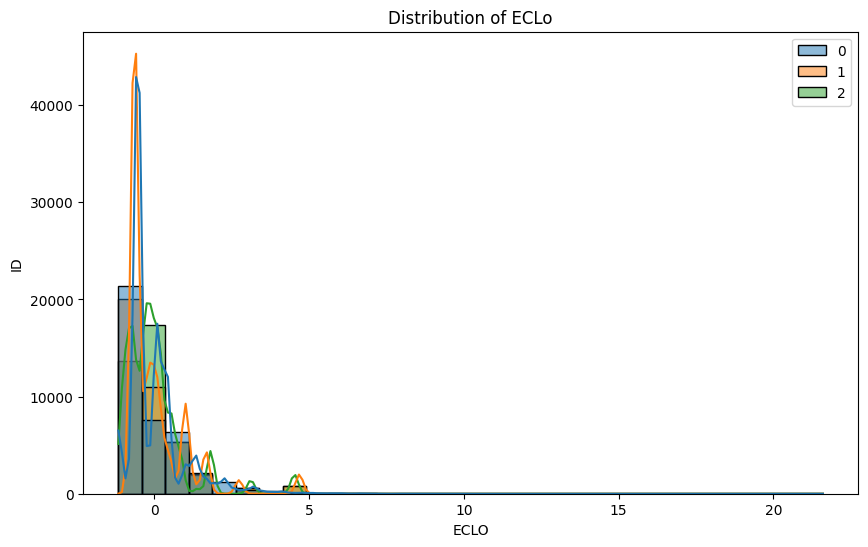

In [ ]:
# histogram 생성
plt.figure(figsize=(10, 6))
sns.histplot(train_std, bins=30, kde=True)
plt.title('Distribution of ECLo')
plt.xlabel('ECLO')
plt.ylabel('ID')
plt.show()

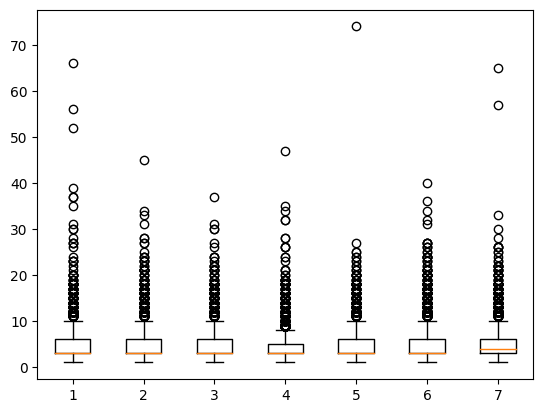

In [ ]:
import matplotlib.pyplot as plt

plt.boxplot([train_df[train_df['요일'] == '월요일'].loc[:,'ECLO',],
             train_df[train_df['요일'] == '화요일'].loc[:,'ECLO',],
             train_df[train_df['요일'] == '수요일'].loc[:,'ECLO'],
             train_df[train_df['요일'] == '목요일'].loc[:,'ECLO',],
             train_df[train_df['요일'] == '금요일'].loc[:,'ECLO',],
             train_df[train_df['요일'] == '토요일'].loc[:,'ECLO',],
             train_df[train_df['요일'] == '일요일'].loc[:,'ECLO',]])
plt.show()

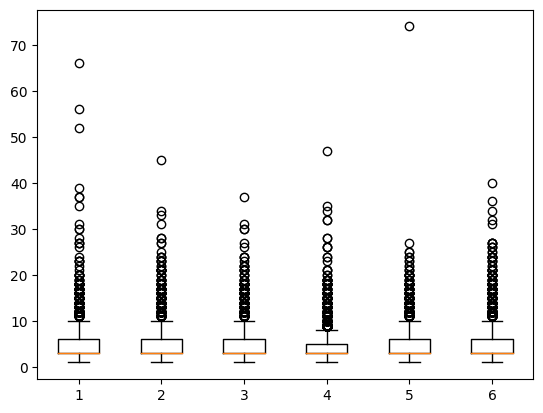

In [ ]:
import matplotlib.pyplot as plt

plt.boxplot([train_df[train_df['요일'] == '월요일'].loc[:,'ECLO',],
             train_df[train_df['요일'] == '화요일'].loc[:,'ECLO',],
             train_df[train_df['요일'] == '수요일'].loc[:,'ECLO'],
             train_df[train_df['요일'] == '목요일'].loc[:,'ECLO',],
             train_df[train_df['요일'] == '금요일'].loc[:,'ECLO',],
             train_df[(train_df['요일'] == '토요일')|(train_df['요일'] == '토요일')].loc[:,'ECLO']])
plt.show()

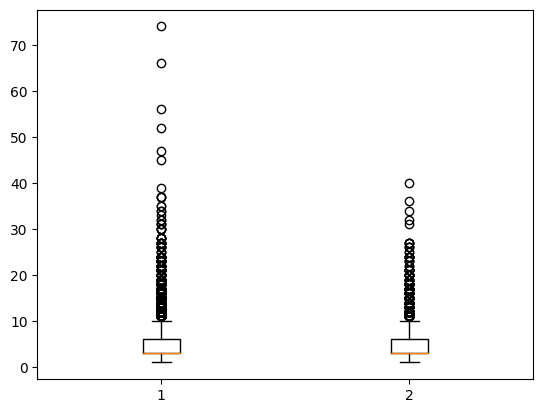

In [ ]:
import matplotlib.pyplot as plt

plt.boxplot([train_df[(train_df['요일'] == '월요일')|
                      (train_df['요일'] == '화요일')|
                      (train_df['요일'] == '수요일')|
                      (train_df['요일'] == '목요일')|
                      (train_df['요일'] == '금요일')].loc[:,'ECLO'],
             train_df[(train_df['요일'] == '토요일')|(train_df['요일'] == '토요일')].loc[:,'ECLO']])
plt.show()

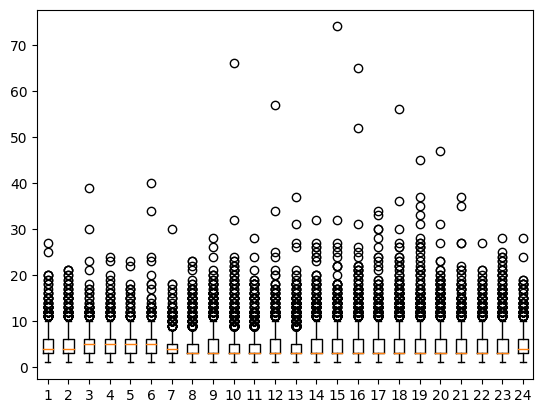

In [ ]:
plt.boxplot([train_df[train_df['시간'] == 0].loc[:,'ECLO',],
              train_df[train_df['시간'] == 1].loc[:,'ECLO',],
              train_df[train_df['시간'] == 2].loc[:,'ECLO'],
              train_df[train_df['시간'] == 3].loc[:,'ECLO',],
              train_df[train_df['시간'] == 4].loc[:,'ECLO',],
              train_df[train_df['시간'] == 5].loc[:,'ECLO',],
              train_df[train_df['시간'] == 6].loc[:,'ECLO',],
             train_df[train_df['시간'] == 7].loc[:,'ECLO',],
             train_df[train_df['시간'] == 8].loc[:,'ECLO',],
             train_df[train_df['시간'] == 9].loc[:,'ECLO',],
             train_df[train_df['시간'] == 10].loc[:,'ECLO',],
             train_df[train_df['시간'] == 11].loc[:,'ECLO',],
             train_df[train_df['시간'] == 12].loc[:,'ECLO',],
             train_df[train_df['시간'] == 13].loc[:,'ECLO',],
             train_df[train_df['시간'] == 14].loc[:,'ECLO',],
             train_df[train_df['시간'] == 15].loc[:,'ECLO',],
             train_df[train_df['시간'] == 16].loc[:,'ECLO',],
             train_df[train_df['시간'] == 17].loc[:,'ECLO',],
             train_df[train_df['시간'] == 18].loc[:,'ECLO',],
             train_df[train_df['시간'] == 19].loc[:,'ECLO',],
             train_df[train_df['시간'] == 20].loc[:,'ECLO',],
             train_df[train_df['시간'] == 21].loc[:,'ECLO',],
             train_df[train_df['시간'] == 22].loc[:,'ECLO',],
             train_df[train_df['시간'] == 23].loc[:,'ECLO',]])
plt.show()

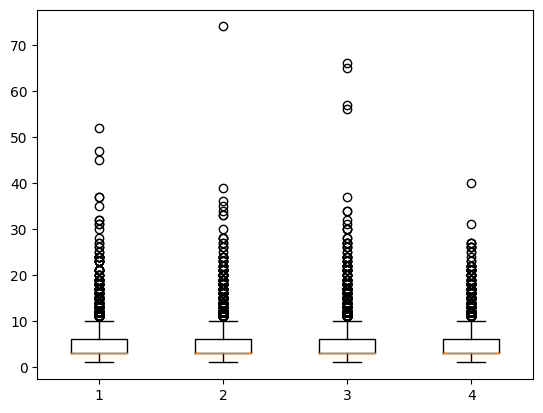

In [ ]:
plt.boxplot([train_df[(train_df['월'] >= 3)&(train_df['월'] <= 5)].loc[:,'ECLO',],
             train_df[(train_df['월'] >= 6)&(train_df['월'] <= 8)].loc[:,'ECLO',],
             train_df[(train_df['월'] >= 9)&(train_df['월'] <= 11)].loc[:,'ECLO'],
             train_df[(train_df['월'] == 12)|(train_df['월'] >= 1)&(train_df['월'] <= 2)].loc[:,'ECLO']])
plt.show()

피처, 타겟 분리 라벨인코딩

In [88]:
#X = train_df.drop(columns=['ECLO','부상자수','경상자수','중상자수','사망자수','피해운전자 상해정도','피해운전자 연령','피해운전자 차종','가해운전자 상해정도',
                           #'가해운전자 연령','가해운전자 성별','가해운전자 차종','법규위반','사고유형 - 세부분류','피해운전자 성별','도시'])
X = train_df.drop(columns=['ID','ECLO'])
y = train_df['ECLO']
test_df = test_df.drop(columns=['ID'])
print(X.shape, y.shape, test_df.shape)

(39609, 17) (39609,) (10963, 17)


In [89]:
from sklearn.preprocessing import LabelEncoder

FEATURE = ['기상상태','노면상태','사고유형','구','동','도로형태1','도로형태2','요일','도시','도로형태3']
for i in FEATURE:
    le = LabelEncoder()
    X[i]= le.fit_transform(X[i])
    test_df[i]= le.transform(test_df[i])

X

,요일,기상상태,노면상태,사고유형,연,월,일,시간,도시,구,동,도로형태1,도로형태2,도로형태3,어린이CCTV설치대수,CCTV개수,평균속도
0,6,2,0,0,2019,1,1,0,0,7,40,2,5,0,2.0,1.0,0.0
1,0,2,0,1,2019,1,4,4,0,7,40,0,2,0,2.0,1.0,0.0
2,1,2,0,0,2019,1,10,15,0,7,40,0,2,0,2.0,1.0,0.0
3,6,2,0,0,2019,1,15,17,0,7,40,2,9,0,2.0,1.0,0.0
4,5,2,0,0,2019,1,19,9,0,7,40,2,5,0,2.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39604,4,2,0,0,2021,7,4,13,0,7,55,2,5,0,0.0,0.0,0.0
39605,2,2,0,1,2021,12,22,18,0,7,55,2,5,0,0.0,0.0,0.0
39606,4,2,4,1,2021,7,11,17,0,3,182,2,5,1,0.0,1.0,100.0
39607,6,3,4,2,2021,9,21,16,0,4,47,2,5,1,1.0,0.0,0.0


In [90]:
test_df

,요일,기상상태,노면상태,사고유형,연,월,일,시간,도시,구,동,도로형태1,도로형태2,도로형태3,어린이CCTV설치대수,CCTV개수,평균속도
0,5,2,0,0,2022,1,1,1,0,6,99,0,3,0,5.0,4.0,52.5
1,6,2,0,1,2022,1,4,21,0,6,99,2,5,0,5.0,4.0,52.5
2,2,2,0,1,2022,1,5,16,0,6,99,2,5,0,5.0,4.0,52.5
3,5,2,0,1,2022,1,8,23,0,6,99,0,2,0,5.0,4.0,52.5
4,1,2,0,1,2022,1,13,7,0,6,99,2,5,0,5.0,4.0,52.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10958,2,2,0,1,2022,11,2,0,0,4,10,2,5,2,1.0,0.0,0.0
10959,2,2,0,0,2022,11,9,10,0,3,33,0,2,1,0.0,0.0,0.0
10960,1,2,0,1,2022,11,10,13,0,7,193,2,5,0,0.0,0.0,0.0
10961,0,2,0,1,2022,11,18,15,0,7,105,0,2,0,0.0,0.0,0.0


모델 훈련 및 예측

In [91]:
#xgboost3.csv
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

def objective(trial):
    # XGBoost의 하이퍼파라미터를 설정합니다.
    param = {
        'objective': 'reg:squaredlogerror',
        'eval_metric': 'rmsle',
        'lambda': trial.suggest_float('lambda', 1e-3, 0.1),
        'alpha': trial.suggest_float('alpha', 1e-3, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1),
        'subsample': trial.suggest_float('subsample', 0.4, 1),
        'learning_rate': trial.suggest_float('learning_rate',0.0001, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 4,8),
        'min_child_weight': trial.suggest_int('min_child_weight', 2, 50),
    }

    # XGBoost 모델을 생성합니다.
    model = xgb.XGBRegressor(**param)

    # 모델을 훈련합니다.
    model.fit(X_train, np.log1p(y_train), eval_set=[(X_val,np.log1p(y_val))],early_stopping_rounds=100)

    # 검증 데이터에 대한 예측을 수행합니다.
    y_pred = model.predict(X_val)

    # RMSE를 계산하여 반환합니다.
    rmsle = np.sqrt(mean_squared_log_error(y_val, np.expm1(y_pred)))
    return rmsle

# Optuna를 사용하여 하이퍼파라미터 튜닝을 수행합니다.
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# 최적의 하이퍼파라미터를 출력합니다.
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

best_params = trial.params
final_model = xgb.XGBRegressor(
    objective='reg:squaredlogerror',
    eval_metric='rmsle',
    verbosity=0,
    n_jobs=-1,
    tree_method='hist',
    **best_params
)

final_model.fit(X, y, verbose=False)
y_pred = final_model.predict(test_df)

Output hidden; open in https://colab.research.google.com to view.

In [92]:
sample_submission = pd.read_csv('/content/drive/MyDrive/colab/daegu_traffic/sample_submission.csv')
baseline_submission = sample_submission.copy()
baseline_submission['ECLO'] = y_pred
baseline_submission

,ID,ECLO
0,ACCIDENT_39609,4.429391
1,ACCIDENT_39610,4.438511
2,ACCIDENT_39611,4.211820
3,ACCIDENT_39612,4.852262
4,ACCIDENT_39613,4.252000
...,...,...
10958,ACCIDENT_50567,4.594795
10959,ACCIDENT_50568,3.900874
10960,ACCIDENT_50569,3.721994
10961,ACCIDENT_50570,3.888190


In [93]:
baseline_submission.to_csv('xgboost9.csv', index=False)